# Multi-resolution maps of CO in 30 Dor

The idea is to combine the ALMA maps with the APEX maps to fill in the short baselines and get the extended emission.

We already have the Alma map, so we need to get the APEX one

## APEX 12CO map from Okada et al (2019)

We have a cube, so we will sum it in velocity

### Write out a summed image file

In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy import constants
from reproject import reproject_interp

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [2]:
DATAPATH = Path.cwd().parent / "big-data" / "30-Dor-Radio"

In [3]:
infile = "30Dor_CO21_map_30.fits"
hdulist = fits.open(DATAPATH / infile)
hdulist.info()

Filename: /Users/will/Dropbox/muse-hii-regions/big-data/30-Dor-Radio/30Dor_CO21_map_30.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (29, 31, 300)   float64   


Fix the velocity axis of the header before making the WCS

In [4]:
hdu = hdulist[0]
hdu.header["CRVAL3"] = hdu.header["VELO-LSR"]
hdu.header["CD3_3"] = hdu.header["CDELT3"] = hdu.header["DELTAV"]
w = WCS(hdu.header)
w

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'VELOCITY'  
CRVAL : 84.675  -69.0875  235000.0  
CRPIX : 16.6650365417  17.7066070557  150.0  
CD1_1 CD1_2 CD1_3  : -0.00277777784504  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  0.00277777784504  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  1000.0  
NAXIS : 29  31  300

In [5]:
imsum = hdu.data[150:181, ...].sum(axis=0)
fits.PrimaryHDU(
    header=w.celestial.to_header(),
    data=imsum,
).writeto(
    DATAPATH / infile.replace(".fits", "-sum.fits"), 
    overwrite=True,
)

### Compare with the ALMA map

We want this section to be independent of the previous one, so we will read the data in from the file again.

In [6]:
from astropy.convolution import convolve_fft, Gaussian2DKernel

In [7]:
infile = "30Dor_CO21_map_30-sum.fits"
hdu, = fits.open(DATAPATH / infile)
w = WCS(hdu.header)

In [8]:
DATAPATH2 = Path.cwd().parent / "data"
infile2 = "lmc-30dor-ABCD-12co-21-reproject-sum.fits"
hdu2, = fits.open(DATAPATH2 / infile2)
w2 = WCS(hdu2.header)

Make a smooth version of alma image:

In [9]:
w2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 84.688309  -69.105970125  
CRPIX : 220.92793852  213.660785628  
CD1_1 CD1_2  : -5.52742276729e-05  -9.66418424553e-08  
CD2_1 CD2_2  : -4.91681964084e-07  5.53153613478e-05  
NAXIS : 650  650

Find the equivalent RMS smoothing width of APEX map in Alma pixels

In [10]:
apex_fwhm = 30.0 * u.arcsec
alma_plate_scale = w2.wcs.cd[1, 1] * u.deg
apex_sigma_pixels = float(apex_fwhm / alma_plate_scale) / np.sqrt(8.0 * np.log(2))
apex_sigma_pixels

63.97573383427169

In [11]:
kernel = Gaussian2DKernel(apex_sigma_pixels)
im_smooth = convolve_fft(hdu2.data, kernel)

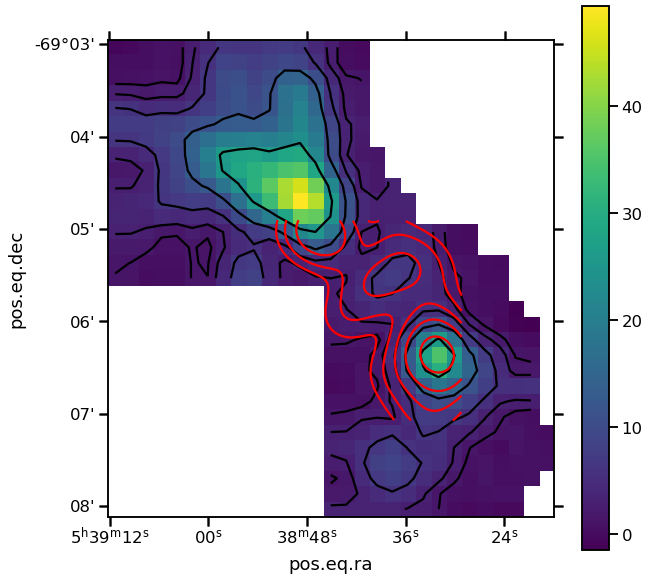

In [12]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    
    subplot_kw=dict(projection=w),
)
im = ax.imshow(hdu.data)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.contour(
    hdu.data, 
    levels=[1.5, 3, 6, 12, 25, 50, 100, 200, 400],
    colors="k",
)


if True:
    ax.contour(
        im_smooth, 
        transform=ax.get_transform(w2),
        levels=[1.5, 3, 6, 12, 25, 50, 100, 200, 400],
        colors="r",
    )
else:
    ax.imshow(
        im_smooth,
        transform=ax.get_transform(w2),
    )
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
fig.colorbar(im, ax=ax)
...;

So that looks good. The contours of the smoothed ALMA map look very similar to the contours of the APEX map.

The biggest differences are close to the edges of the MUSE field because we haven't got any ALMA data outside of that. *Although we could get some!*

The strange thing is that there is not a lot of room for any large-scale emission that would be left over from subtracting the smoothed ALMA map. 

Could it be that the APEX map is missing those same small baselines that ALMA is? No - not possible since APEX is single-dish

## Make a bigger ALMA map

Currently the ALMA map is restricted to the MUSE field.  We wil lmake another one that extends another 60 arcsec on each side. This will eliminate any edge effects in the MUSE field. 

In [13]:
uids = ["218a", "2192", "219a"]
line_id = "12CO21"
label = "sum"
PREFIX = "Alma-2019.1.00843.S-30_doradus"

data_12co = {
    uid: fits.open(DATAPATH / f"{PREFIX}_{line_id}-{uid}-{label}.fits")["PRIMARY"]
    for uid in uids
}

In [14]:
data_12co

{'218a': <astropy.io.fits.hdu.image.PrimaryHDU at 0x7fbb89540b80>,
 '2192': <astropy.io.fits.hdu.image.PrimaryHDU at 0x7fbb89559f10>,
 '219a': <astropy.io.fits.hdu.image.PrimaryHDU at 0x7fbbb97f2cd0>}

Make the output projection

In [15]:
hdr = hdu2.header.copy()
margin_arcsec = 60.0
pix_scale = 0.2
margin_pix = int(margin_arcsec / pix_scale)
hdr["NAXIS1"] += 2 * margin_pix
hdr["NAXIS2"] += 2 * margin_pix
hdr["CRPIX1"] += margin_pix
hdr["CRPIX2"] += margin_pix
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1250                                                  
NAXIS2  =                 1250                                                  
ZBLANK  =          -2147483647 / null value in the compressed integer array     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '           / Image data format                              
HDUCLAS2= 'DATA    '           / this extension contains the data itself        
ERRDATA = 'STAT    '        

In [16]:
images = [
    reproject_interp(hdu, hdr, return_footprint=False)
    for hdu in data_12co.values()
]

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


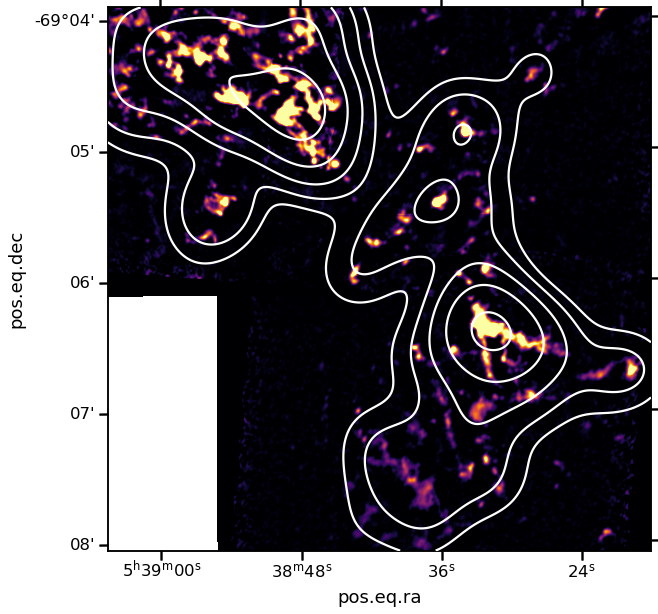

In [17]:
bigim = np.nanmedian(
    np.stack(images),
    axis=0,
)
#im[~np.isfinite(im)] = 0.0
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw=dict(projection=WCS(hdr)),
)
ax.imshow(
    bigim,
     vmin=0.0, 
     vmax=1e2,
    cmap="inferno",
)
ax.contour(
    convolve_fft(bigim, kernel),
    levels=[1.5, 3, 6, 12, 25, 50, 100, 200, 400],
    colors="white",
)
ax.set_aspect("equal")

This shows the original ALMA image in color map, and the image smoothed to 30 arcsec fwhm in contours. 

### Reproject smooth ALMA map to APEX pixels

In [18]:
imr = reproject_interp(
    (convolve_fft(bigim, kernel), hdr),
    hdu.header,
    return_footprint=False,
)

We can subtract the smoothed ALMA map from the APEX map to see what large-scale emission we are supposedly missing: 

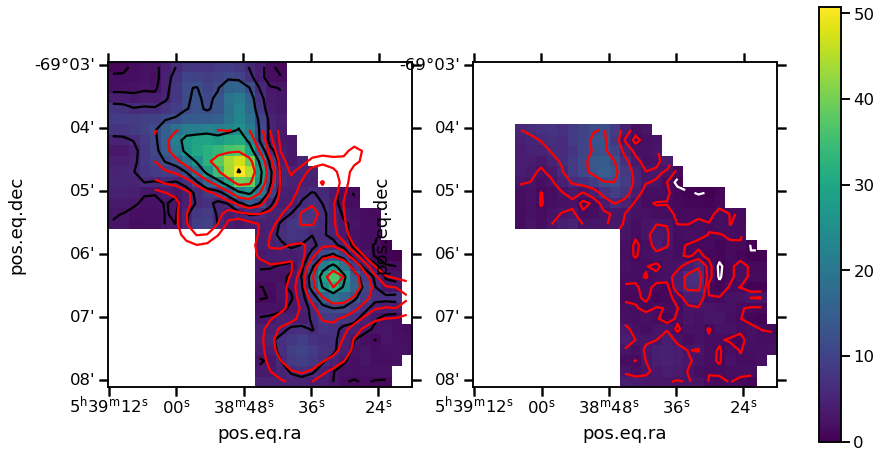

In [19]:
fig, [ax, axx] = plt.subplots(
    1, 2,
    figsize=(15, 8),
    sharex=True,
    sharey=True,
    subplot_kw=dict(projection=w),
)
levels = [1.5, 3, 6, 12, 25, 50, 100, 200, 400]
apex_map = hdu.data - np.nanmin(hdu.data)
im = ax.imshow(apex_map)
ax.contour(
    apex_map, 
    levels=levels,
    colors="k",
)
ax.contour(
    imr, 
    levels=levels,
    colors="r",
)
diff = apex_map -  1.0 * imr
axx.imshow(diff, vmin=im.norm.vmin, vmax=im.norm.vmax)
axx.contour(diff, levels=levels, colors="r")
axx.contour(diff, levels=[0], colors="w")
fig.colorbar(im, ax=[ax, axx])
...;

In [29]:
m = np.isfinite(diff) & (diff > 0.0)
np.nansum(diff[m]), np.nansum(imr[m]), np.nansum(apex_map[m])

(1219.9334312169149, 2201.2421541502467, 3421.1755853671616)

So this shows that the ALMA map captures 65% of the flux

So now we can reproject the difference map back onto the MUSE grid.  We have two versions, `diff_big` is a larger field of view, while `diff_muse` is just the original MUSE field. 

In [25]:
diff_big = reproject_interp(
    (diff, hdu.header),
    hdr,
    return_footprint=False,
)
diff_muse = reproject_interp(
    (diff, hdu.header),
    hdu2.header,
    return_footprint=False,
)

In [30]:
np.nanmax(diff_muse), np.nanmax(hdu2.data)

(11.292356213271793, 452.80129210551826)

So, I will plot these to see if we can see the effects of the APEX addition.  **It turns out that there is no practical difference.**  The additional flux that the single-dish measurements give is negligible compared with what ALMA detects. 

This is because despite being 35% of the total flux, its maximum value is only 2% of the ALMA peaks.

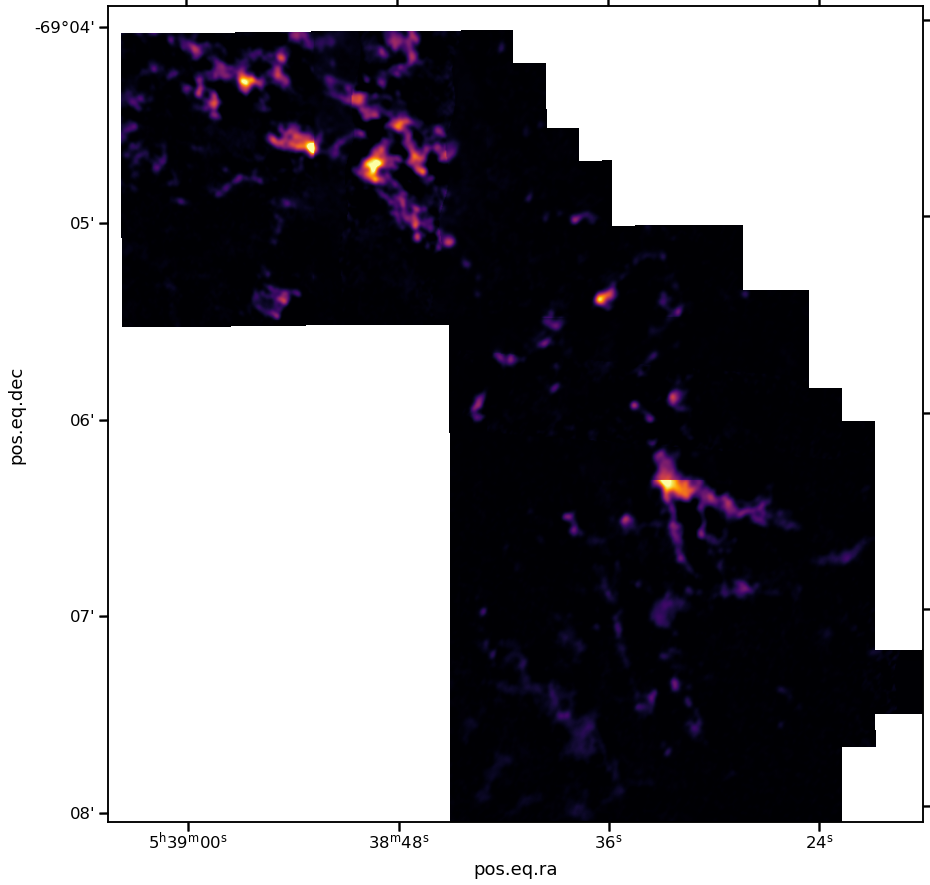

In [31]:
fig, ax = plt.subplots(
    figsize=(15, 15),
    subplot_kw=dict(projection=WCS(hdr)),
)
ax.imshow(
    diff_big + bigim,
#    bigim,
#    diff_muse,
    vmin=0.0,
    vmax=400.0,
    cmap="inferno",
)

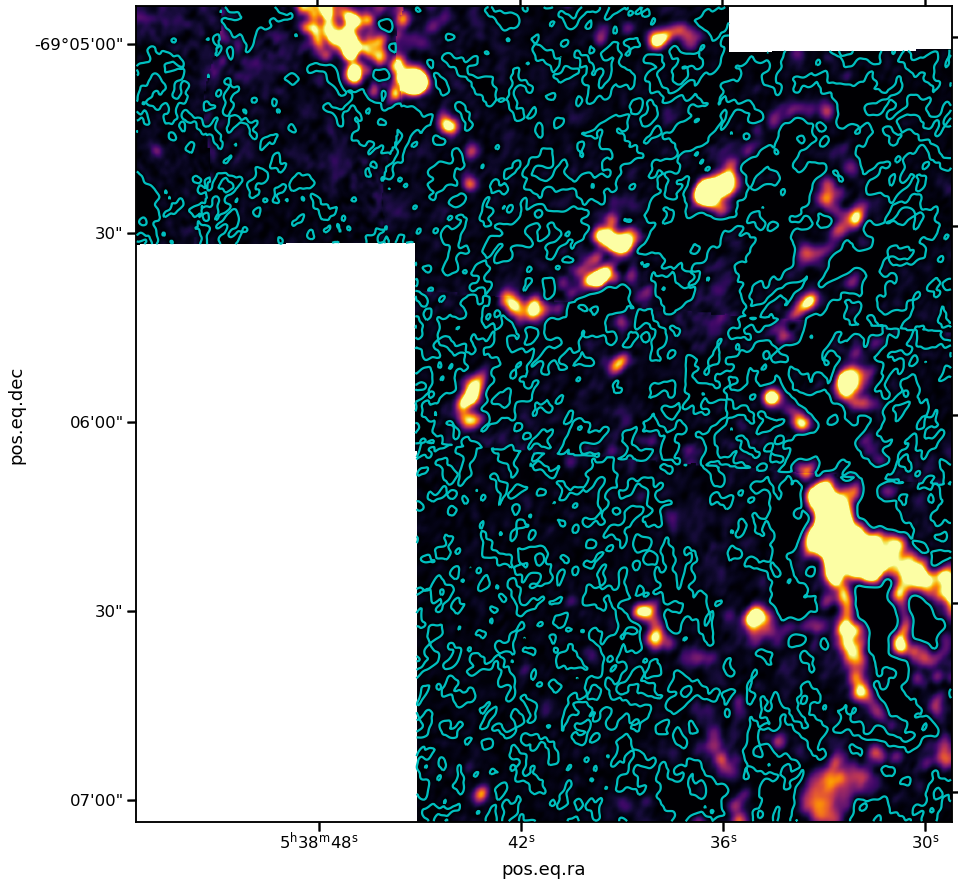

In [32]:
fig, ax = plt.subplots(
    figsize=(15, 15),
    subplot_kw=dict(projection=w2),
)
ax.imshow(
    diff_muse + hdu2.data,
#    bigim,
#    diff_muse,
    vmin=0.0,
    vmax=100.0,
    cmap="inferno",
)
ax.contour(
    diff_muse + hdu2.data,
    levels=[0],
    colors="c",
)

The contours show the zero-level. So there are still lots of negative regions in the combined map.  This is probably because mof still-missing short baselines.

## Write out FITS files of the combined maps

In [34]:
fits.PrimaryHDU(
    data=diff_muse + hdu2.data,
    header=hdu2.header,
).writeto(
    DATAPATH2 / "lmc-30dor-ABCD-12co-reproject.fits",
    overwrite=True,
)
fits.PrimaryHDU(
    data=diff_big + bigim,
    header=hdr,
).writeto(
    DATAPATH2 / "lmc-30dor-EXTEND-12co-reproject.fits",
    overwrite=True,
)